## Spot Analysis of BF Correction

Originally written by Alex Broughton



In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_11/conda/envs/lsst-scipipe-3.0.0-ext/eups 	setup
lsst_distrib          g64fc59b30a+aba2a66198 	w_2022_11 w_latest current setup


In [2]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()



slacAmps = {'C10':'AMP01','C11':'AMP02','C12':'AMP03','C13':'AMP04',\
           'C14':'AMP05','C15':'AMP06','C16':'AMP07','C17':'AMP08',\
           'C07':'AMP09','C06':'AMP10','C05':'AMP11','C04':'AMP12',\
           'C03':'AMP13','C02':'AMP14','C01':'AMP15','C00':'AMP16'}

In [3]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/butler.yaml"
butler = Butler(repo_path)
registry = butler.registry

# Pick a sensor
# Interesting sensors: R10_S11, R02_S00
sensor = "R24_S11"
det = 112

#### Read in BFKs

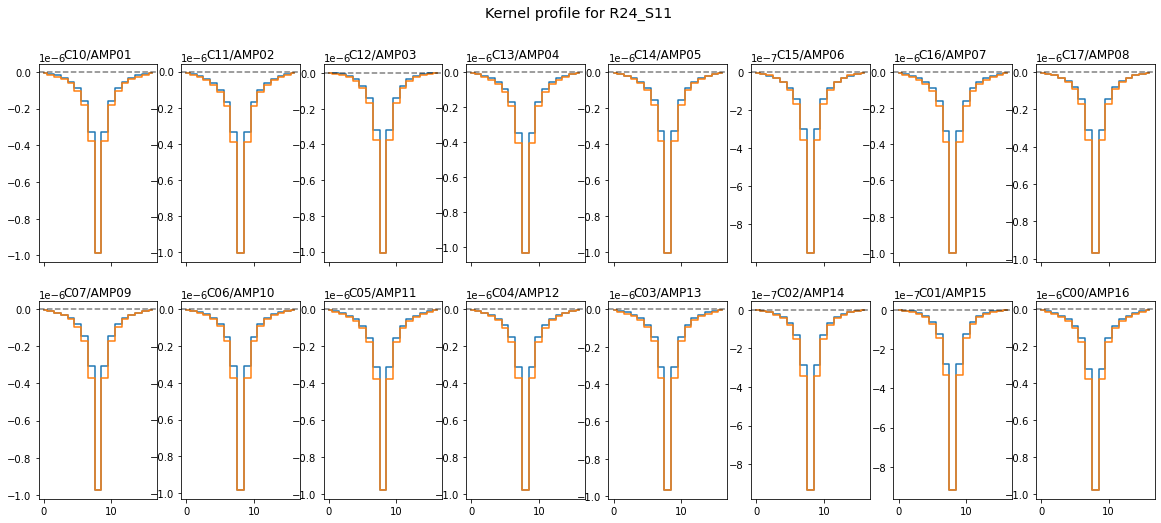

In [4]:
bfk = butler.get('bfk', detector=det, instrument='LSSTCam', collections='u/abrought/BF/run_13144/bfks2')
bfk.ampKernels

fig, axs = plt.subplots(2,8, sharex=True, sharey=False, figsize=(20,8), facecolor='w')
plt.suptitle("Kernel profile for " + sensor, fontsize="x-large")   
for i, amp in enumerate(camera[0].getAmplifiers()):
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    im = ax.plot(bfk.ampKernels[amp.getName()][:,8], drawstyle='steps-mid')
    im2 = ax.plot(bfk.ampKernels[amp.getName()][8,:], drawstyle='steps-mid')
    ax.axhline(0.0,linestyle="--", color="black", alpha=0.5)
    ax.set(title=amp.getName() + "/" + slacAmps[amp.getName()])


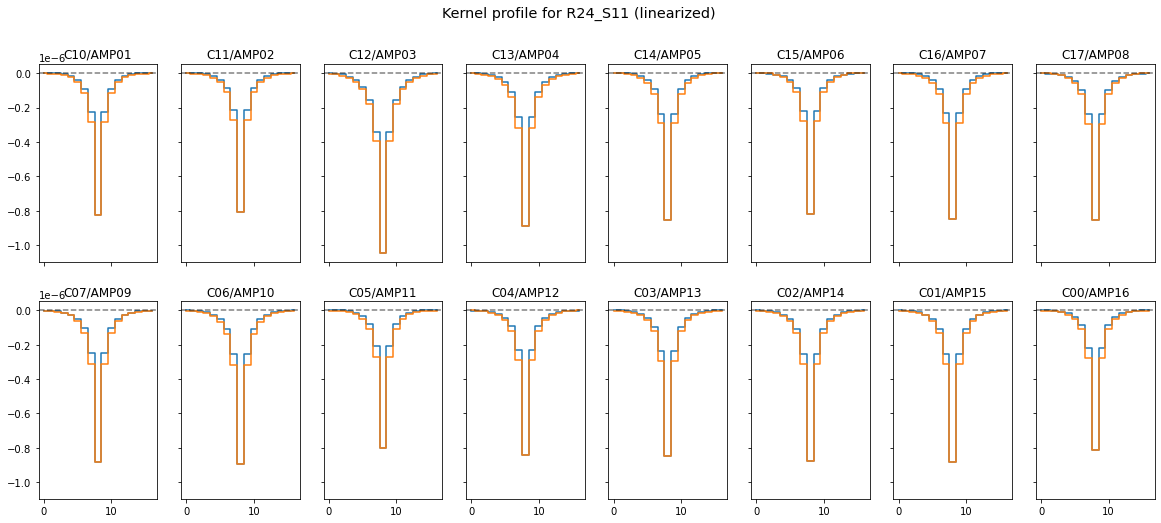

In [5]:
bfk_linearized = butler.get('bfk', detector=det, instrument='LSSTCam', collections='u/abrought/BF/run_13144/bfks_linearized')
bfk_linearized.ampKernels

fig, axs = plt.subplots(2,8, sharex=True, sharey=True, figsize=(20,8), facecolor='w')
plt.suptitle("Kernel profile for " + sensor + " (linearized)", fontsize="x-large")   
for i, amp in enumerate(camera[0].getAmplifiers()):
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    im = ax.plot(bfk_linearized.ampKernels[amp.getName()][:,8], drawstyle='steps-mid')
    im2 = ax.plot(bfk_linearized.ampKernels[amp.getName()][8,:], drawstyle='steps-mid')
    ax.axhline(0.0,linestyle="--", color="black", alpha=0.5)
    ax.set(title=amp.getName() + "/" + slacAmps[amp.getName()])


##### Linearity residuals

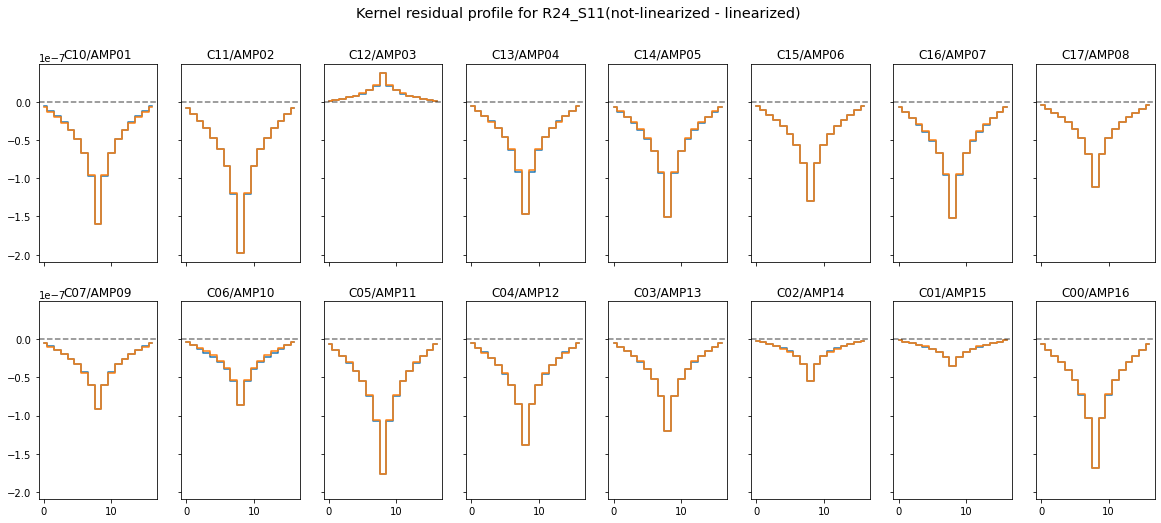

In [6]:
fig, axs = plt.subplots(2,8, sharex=True, sharey=True, figsize=(20,8), facecolor='w')
plt.suptitle("Kernel residual profile for " + sensor + "(not-linearized - linearized)", fontsize="x-large")   
for i, amp in enumerate(camera[0].getAmplifiers()):
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    im = ax.plot(bfk.ampKernels[amp.getName()][:,8] - bfk_linearized.ampKernels[amp.getName()][:,8], drawstyle='steps-mid')
    im2 = ax.plot(bfk.ampKernels[amp.getName()][8,:] - bfk_linearized.ampKernels[amp.getName()][8,:], drawstyle='steps-mid')
    ax.axhline(0.0,linestyle="--", color="black", alpha=0.5)
    ax.set(title=amp.getName() + "/" + slacAmps[amp.getName()])


#### Read in PTCs

In [7]:
ptcdir = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/u/abrought/BF/run_13144/ptcs/20220207T220227Z/ptc/"
ptcfile = glob.glob(ptcdir + "*" + sensor + "*.fits")[0]

hdu_ptc = fits.open(ptcfile)
hdu_ptc[1].columns

ColDefs(
    name = 'AMPLIFIER_NAME'; format = '3A'
    name = 'PTC_FIT_TYPE'; format = '16A'
    name = 'COV_MATRIX_SIDE'; format = 'K'
    name = 'INPUT_EXP_ID_PAIRS'; format = '676K'; dim = '(2,1,338)'
    name = 'EXP_ID_MASK'; format = '338L'; dim = '(338)'
    name = 'RAW_EXP_TIMES'; format = '338D'; dim = '(338)'
    name = 'RAW_MEANS'; format = '338D'; dim = '(338)'
    name = 'RAW_VARS'; format = '338D'; dim = '(338)'
    name = 'GAIN'; format = 'D'
    name = 'GAIN_ERR'; format = 'D'
    name = 'NOISE'; format = 'D'
    name = 'NOISE_ERR'; format = 'D'
    name = 'PTC_FIT_PARS'; format = '3D'; dim = '(3)'
    name = 'PTC_FIT_PARS_ERROR'; format = '3D'; dim = '(3)'
    name = 'PTC_FIT_CHI_SQ'; format = 'D'
    name = 'COVARIANCES'; format = '21632D'; dim = '(21632)'
    name = 'COVARIANCES_MODEL'; format = '21632D'; dim = '(21632)'
    name = 'COVARIANCES_SQRT_WEIGHTS'; format = '21632D'; dim = '(21632)'
    name = 'A_MATRIX'; format = '64D'; dim = '(64)'
    name = 'B_MATRIX';

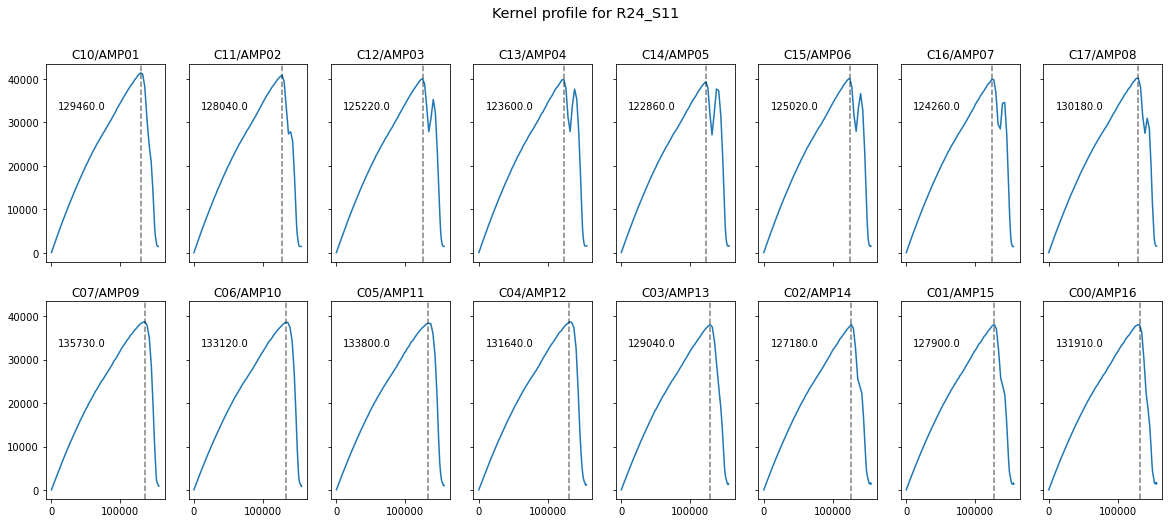

In [8]:
ptc = butler.get('ptc', detector=det, instrument='LSSTCam', collections='u/abrought/BF/run_13144/ptcs')


fig, axs = plt.subplots(2,8, sharex=True, sharey=True, figsize=(20,8), facecolor='w')
plt.suptitle("Kernel profile for " + sensor, fontsize="x-large")   
for i, amp in enumerate(camera[0].getAmplifiers()):
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    flux = [mean * ptc.gain[amp.getName()] for mean in ptc.rawMeans[amp.getName()]]
    im = ax.plot(flux, ptc.rawVars[amp.getName()])
    ax.set(title=amp.getName() + "/" + slacAmps[amp.getName()])
    ax.axvline(flux[np.argmax(ptc.rawVars[amp.getName()])], linestyle="--", color="black", alpha=0.5)
    ax.text(10000, 33000, str(round(flux[np.argmax(ptc.rawVars[amp.getName()])], -1)))
    
    

1.4657718461592755
1.4646033431273355
1.470905394046284
1.4657784565626273
1.4772514450347431
1.46675868887136
1.4751443096980066
1.4837537334291997
1.519456974176924
1.5274509068529307
1.5275301849584788
1.524750290000302
1.526401235049969
1.5273839367804367
1.5266292556842
1.529671205967203


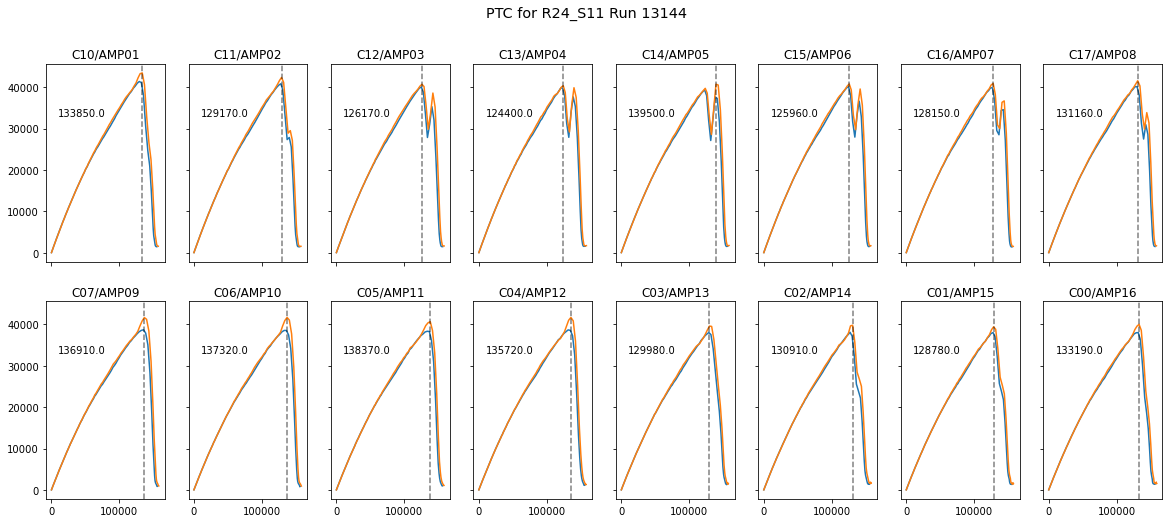

In [9]:
ptc_linearized = butler.get('ptc', detector=det, instrument='LSSTCam', collections='u/abrought/BF/run_13144/ptcs_linearized')

fig, axs = plt.subplots(2,8, sharex=True, sharey=True, figsize=(20,8), facecolor='w')
plt.suptitle("PTC for " + sensor + " Run 13144", fontsize="x-large")  
ptc_turnoffs = []
ptc_turnoffs2 = []
for i, amp in enumerate(camera[0].getAmplifiers()):
    print(ptc.gain[amp.getName()])
    ax = axs[0 if i < 8 else 1][i if i < 8 else i-8]
    flux = [mean * ptc_linearized.gain[amp.getName()] for mean in ptc_linearized.rawMeans[amp.getName()]]
    flux2 = [mean * ptc.gain[amp.getName()] for mean in ptc.rawMeans[amp.getName()]]
    im2 = ax.plot(flux2, ptc.rawVars[amp.getName()])
    im = ax.plot(flux, ptc_linearized.rawVars[amp.getName()])
    ax.set(title=amp.getName() + "/" + slacAmps[amp.getName()])
    ax.axvline(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])], linestyle="--", color="black", alpha=0.5)
    ax.text(10000, 33000, str(round(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])], -1)))
    ptc_turnoffs.append(flux[np.argmax(ptc_linearized.rawVars[amp.getName()])])
    ptc_turnoffs2.append(flux2[np.argmax(ptc.rawVars[amp.getName()])])
    
    

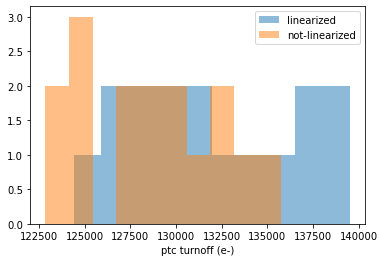

In [10]:
plt.hist(ptc_turnoffs, alpha=0.5, label="linearized")
plt.hist(ptc_turnoffs2, alpha=0.5, label="not-linearized")
plt.xlabel("ptc turnoff (e-)")
plt.legend()

##### Linearizer

Text(0.5, 1.0, 'Spline knots R24_S11,  Max flux=97000 ADU')

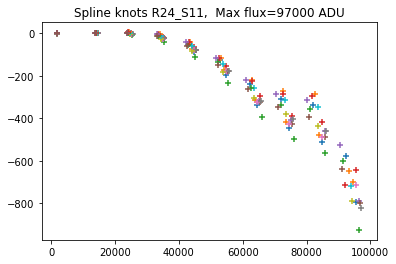

In [11]:
lin = butler.get('linearizer', detector=112, instrument='LSSTCam', collections='u/abrought/BF/run_13144/linearity')
sensor = "R24_S11"
plt.subplot(1,1,1)

offset = 0.0
mx = 0
for it, amp in enumerate(camera[0].getAmplifiers()):
    centers, values = np.split(lin.linearityCoeffs[amp.getName()], 2)
    plt.scatter(centers, values + it * offset, marker='+')
    if max(centers) > mx:
        mx = max(centers)
plt.title("Spline knots " + sensor + ",  Max flux=" + str(int(round(mx,-3))) + " ADU")